<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Scatter Plot**


Estimated time needed: **45** minutes


## Overview

In this lab, you will focus on creating and interpreting scatter plots to visualize relationships between variables and trends in the dataset. The provided dataset will be directly loaded into a pandas DataFrame, and various scatter plot-related visualizations will be created to explore developer trends, compensation, and preferences.



## Objectives


In this lab, you will:

- Create and analyze scatter plots to examine relationships between variables.

- Use scatter plots to identify trends and patterns in the dataset.

- Focus on visualizations centered on scatter plots for better data-driven insights.


## Setup: Working with the Database



**Install and import the required libraries**


In [2]:
#!pip install pandas
#!pip install matplotlib

import pandas as pd
import matplotlib.pyplot as plt

#### Step 1: Load the dataset


In [3]:
file_path = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/n01PQ9pSmiRX6520flujwQ/survey-data.csv"

df = pd.read_csv(file_path)


In [4]:
import numpy as np
import pandas as pd

def to_num(s):
    return pd.to_numeric(s, errors="coerce")

def parse_age_mid(age):
    if pd.isna(age): return np.nan
    s = str(age)
    m = pd.Series([s]).str.extract(r"(\d+)\s*-\s*(\d+)").astype(float)
    if not m.isna().all(axis=None):
        return float(m.mean(axis=1).iloc[0])
    if "Under" in s: return 16.0
    if "or older" in s: return 70.0
    return np.nan

def parse_years(x):
    if pd.isna(x): return np.nan
    if isinstance(x, str):
        t = x.strip().lower()
        if t.startswith("less"): return 0.5
        if t.startswith("more"): return 51.0
        if t == "none": return np.nan
    return pd.to_numeric(x, errors="coerce")

def cap_money(x, max_cap=5_000_000):
    x = to_num(x)
    x = x.where((x > 0) & (x < max_cap))
    return x

def map_sopartfreq(x):
    if pd.isna(x): return np.nan
    s = str(x).strip().lower()
    if "daily" in s: return 5
    if "few times per week" in s or "weekly" in s: return 4
    if "few times per month" in s or "monthly" in s: return 3
    if "few times per year" in s or "year" in s: return 2
    if "never" in s: return 1
    return np.nan

dfc = df.copy()

# Core numeric conversions
dfc["AgeNum"] = dfc["Age"].apply(parse_age_mid)
dfc["YearsCodePro_num"] = dfc["YearsCodePro"].apply(parse_years)

dfc["ConvertedCompYearly_num"] = cap_money(dfc.get("ConvertedCompYearly"))
dfc["CompTotal_num"] = cap_money(dfc.get("CompTotal"))

# Satisfaction columns (your CSV often uses these as numeric already)
dfc["JobSat_num"] = to_num(dfc.get("JobSat"))
dfc["JobSatPoints_6_num"] = to_num(dfc.get("JobSatPoints_6"))

# Participation frequency
dfc["SOPartFreq_score"] = dfc.get("SOPartFreq").apply(map_sopartfreq) if "SOPartFreq" in dfc.columns else np.nan

# Helpful “first item” for multi-select roles
if "DevType" in dfc.columns:
    dfc["DevType_first"] = dfc["DevType"].astype(str).str.split(";").str[0].str.strip()
else:
    dfc["DevType_first"] = np.nan

print("Cleaned dfc shape:", dfc.shape)
print(dfc[["AgeNum","YearsCodePro_num","ConvertedCompYearly_num","JobSat_num","JobSatPoints_6_num","SOPartFreq_score"]].notna().sum())


Cleaned dfc shape: (65437, 122)
AgeNum                     65115
YearsCodePro_num           51610
ConvertedCompYearly_num    23431
JobSat_num                 29126
JobSatPoints_6_num         29450
SOPartFreq_score           44796
dtype: int64



### Task 1: Exploring Relationships with Scatter Plots



#### 1. Scatter Plot for Age vs. Job Satisfaction



Visualize the relationship between respondents' age (`Age`) and job satisfaction (`JobSatPoints_6`). Use this plot to identify any patterns or trends.




Rows: 29399


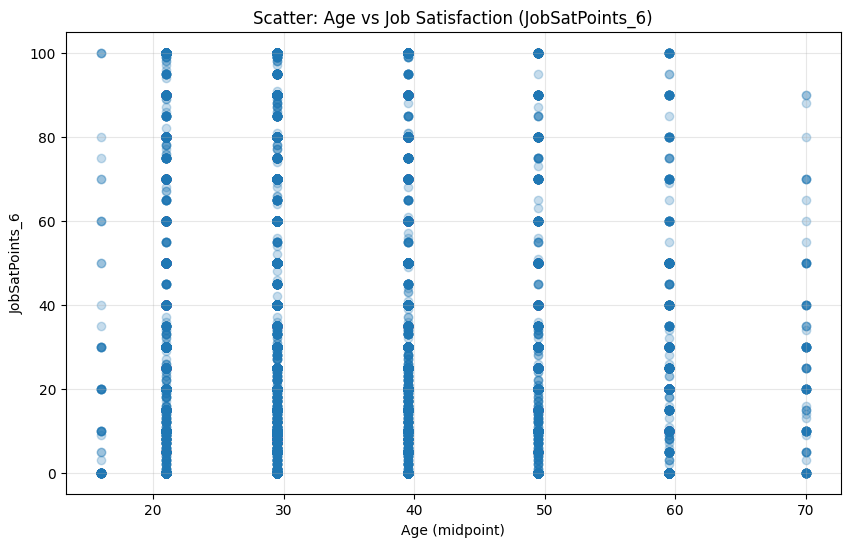

In [5]:
d = dfc.dropna(subset=["AgeNum","JobSatPoints_6_num"]).copy()
print("Rows:", len(d))

plt.figure(figsize=(10,6))
plt.scatter(d["AgeNum"], d["JobSatPoints_6_num"], alpha=0.25)
plt.title("Scatter: Age vs Job Satisfaction (JobSatPoints_6)")
plt.xlabel("Age (midpoint)")
plt.ylabel("JobSatPoints_6")
plt.grid(alpha=0.3)
plt.show()


Interpretation: If points trend upward/downward with age, satisfaction changes with age; if it’s a flat cloud, age is not a strong driver.

In [ ]:
print(df['Age'].unique()) # Run this to see exact strings

['Under 18 years old' '35-44 years old' '45-54 years old'
 '18-24 years old' '25-34 years old' '55-64 years old' 'Prefer not to say'
 '65 years or older']


#### 2. Scatter Plot for Compensation vs. Job Satisfaction


Explore the relationship between yearly compensation (`ConvertedCompYearly`) and job satisfaction (`JobSatPoints_6`) using a scatter plot.


Rows: 16182


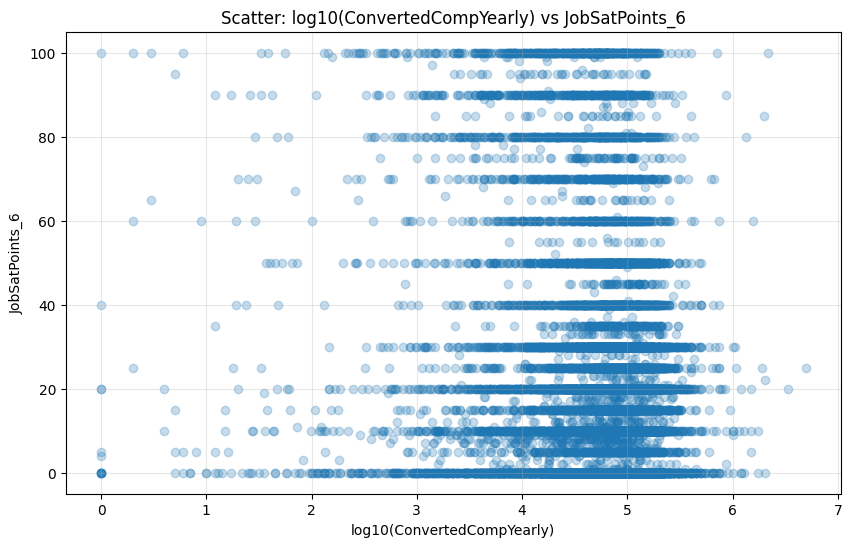

In [6]:
d = dfc.dropna(subset=["ConvertedCompYearly_num","JobSatPoints_6_num"]).copy()
print("Rows:", len(d))

d["Comp_log10"] = np.log10(d["ConvertedCompYearly_num"])

plt.figure(figsize=(10,6))
plt.scatter(d["Comp_log10"], d["JobSatPoints_6_num"], alpha=0.25)
plt.title("Scatter: log10(ConvertedCompYearly) vs JobSatPoints_6")
plt.xlabel("log10(ConvertedCompYearly)")
plt.ylabel("JobSatPoints_6")
plt.grid(alpha=0.3)
plt.show()


Interpretation: Often weak/no trend → pay isn’t the only thing that drives satisfaction.

### Task 2: Enhancing Scatter Plots


#### 1. Scatter Plot with Trend Line for Age vs. Job Satisfaction



Add a regression line to the scatter plot of Age vs. JobSatPoints_6 to highlight trends in the data.


Rows: 29399


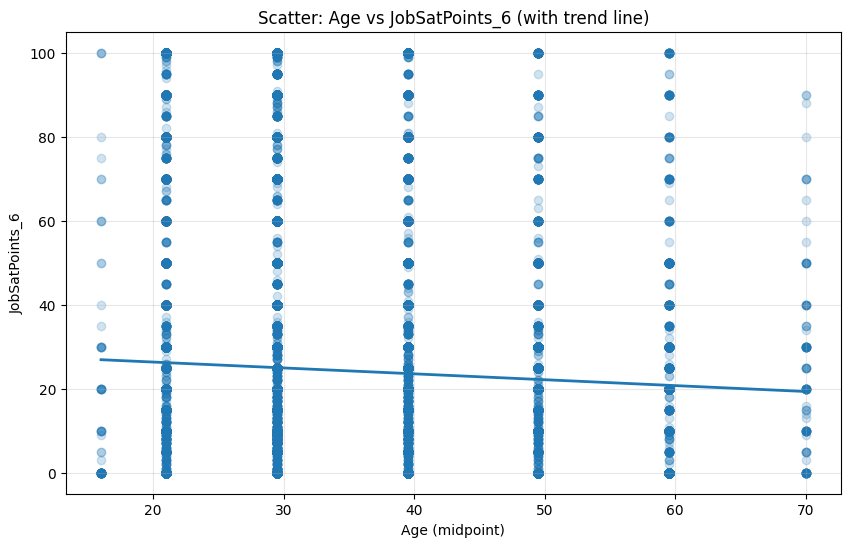

In [7]:
d = dfc.dropna(subset=["AgeNum","JobSatPoints_6_num"]).copy()
print("Rows:", len(d))

x = d["AgeNum"].to_numpy()
y = d["JobSatPoints_6_num"].to_numpy()
b1, b0 = np.polyfit(x, y, 1)
xline = np.linspace(x.min(), x.max(), 200)
yline = b1*xline + b0

plt.figure(figsize=(10,6))
plt.scatter(x, y, alpha=0.2)
plt.plot(xline, yline, linewidth=2)
plt.title("Scatter: Age vs JobSatPoints_6 (with trend line)")
plt.xlabel("Age (midpoint)")
plt.ylabel("JobSatPoints_6")
plt.grid(alpha=0.3)
plt.show()


Interpretation: Slope > 0 suggests satisfaction increases with age; slope < 0 decreases; near 0 means little relationship.

#### 2. Scatter Plot for Age vs. Work Experience


Visualize the relationship between Age (`Age`) and Work Experience (`YearsCodePro`) using a scatter plot.


Rows: 51487


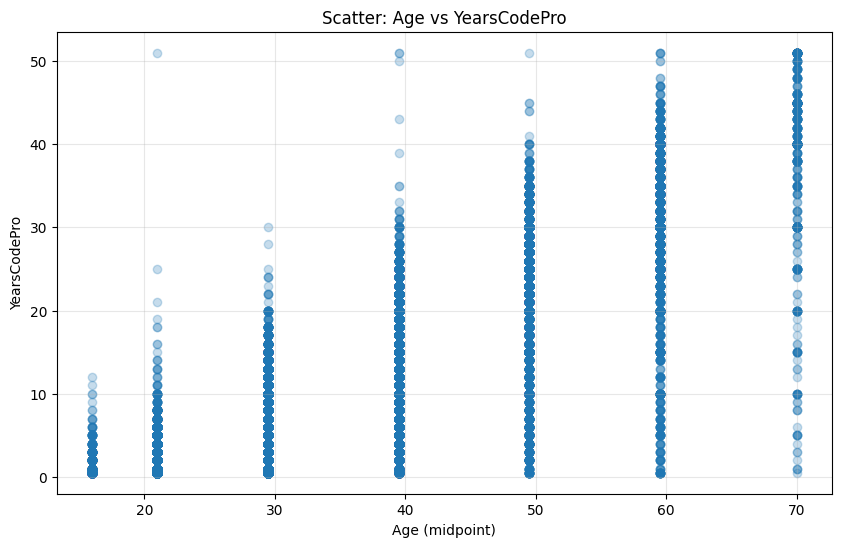

In [8]:
d = dfc.dropna(subset=["AgeNum","YearsCodePro_num"]).copy()
print("Rows:", len(d))

plt.figure(figsize=(10,6))
plt.scatter(d["AgeNum"], d["YearsCodePro_num"], alpha=0.25)
plt.title("Scatter: Age vs YearsCodePro")
plt.xlabel("Age (midpoint)")
plt.ylabel("YearsCodePro")
plt.grid(alpha=0.3)
plt.show()


Interpretation: You’ll usually see a positive trend but with lots of spread.

### Task 3: Combining Scatter Plots with Additional Features


#### 1. Bubble Plot of Compensation vs. Job Satisfaction with Age as Bubble Size



Create a bubble plot to explore the relationship between yearly compensation (`ConvertedCompYearly`) and job satisfaction (`JobSatPoints_6`), with bubble size representing age.


Rows: 16072


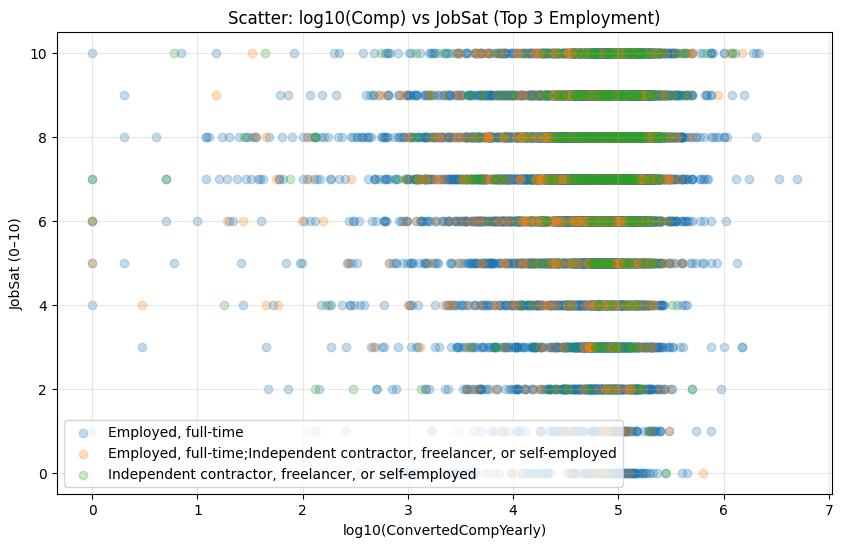

In [9]:
d = dfc.dropna(subset=["ConvertedCompYearly_num","JobSat_num","Employment"]).copy()
print("Rows:", len(d))

d["Comp_log10"] = np.log10(d["ConvertedCompYearly_num"])
top_emp = d["Employment"].value_counts().head(3).index.tolist()
d = d[d["Employment"].isin(top_emp)]

plt.figure(figsize=(10,6))
for e in top_emp:
    sub = d[d["Employment"] == e]
    plt.scatter(sub["Comp_log10"], sub["JobSat_num"], alpha=0.25, label=e)

plt.title("Scatter: log10(Comp) vs JobSat (Top 3 Employment)")
plt.xlabel("log10(ConvertedCompYearly)")
plt.ylabel("JobSat (0–10)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


If points trend upward as compensation increases → pay relates to satisfaction

If no trend → satisfaction depends more on non-pay factors

If larger bubbles cluster higher/lower → age may relate to satisfaction/pay patterns

#### 2. Scatter Plot for Popular Programming Languages by Job Satisfaction


Visualize the popularity of programming languages (`LanguageHaveWorkedWith`) against job satisfaction using a scatter plot. Use points to represent satisfaction levels for each language.


Rows used for language scatter: 116983
Top languages: ['JavaScript', 'SQL', 'HTML/CSS', 'Python', 'TypeScript', 'Bash/Shell (all shells)', 'Java', 'C#', 'C++', 'PHP']


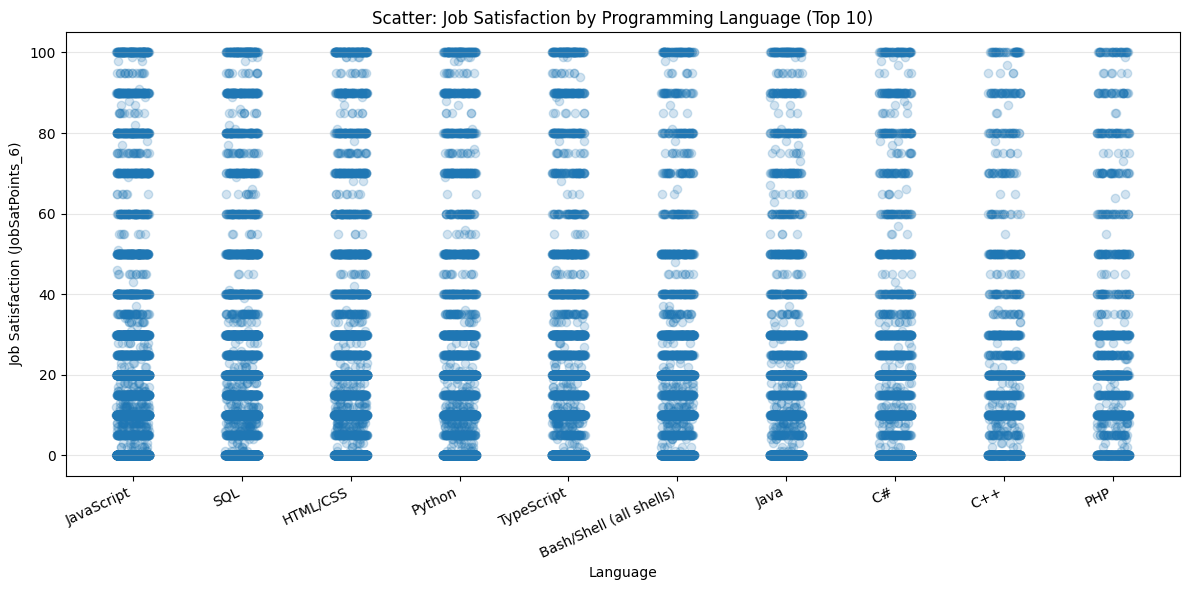

                         count  median   mean
Language                                     
JavaScript                4742    20.0  24.88
SQL                       4197    20.0  24.87
HTML/CSS                  3967    20.0  25.07
Python                    3738    15.0  23.36
TypeScript                3243    20.0  25.31
Bash/Shell (all shells)   2727    20.0  22.79
Java                      2264    20.0  26.23
C#                        2208    20.0  25.40
C++                       1502    15.0  23.20
PHP                       1412    20.0  24.69


In [ ]:
# The dataframe 'df' is already loaded from 'survey-data.csv'
# We can directly select the columns we need from it.
df_l = df[['LanguageHaveWorkedWith', 'JobSatPoints_6']].copy()

df_l["JobSatPoints_6"] = pd.to_numeric(df_l["JobSatPoints_6"], errors="coerce")
df_l = df_l.dropna(subset=["LanguageHaveWorkedWith", "JobSatPoints_6"])

# explode languages
lang_series = df_l["LanguageHaveWorkedWith"].astype(str).str.split(";").explode().str.strip()
# Repeat JobSat values to match exploded rows
rep = df_l["LanguageHaveWorkedWith"].astype(str).str.count(";").add(1).to_numpy()
job_rep = np.repeat(df_l["JobSatPoints_6"].to_numpy(), rep)

df_lang = pd.DataFrame({"Language": lang_series, "JobSat": job_rep}).dropna()

# top 10 languages
top_langs = df_lang["Language"].value_counts().head(10).index.tolist()
df_lang = df_lang[df_lang["Language"].isin(top_langs)].copy()

print("Rows used for language scatter:", len(df_lang))
print("Top languages:", top_langs)

# Optional: subsample so it doesn't overplot (keeps shapes)
if len(df_lang) > 30000:
    df_lang = df_lang.sample(30000, random_state=42)

# Encode languages as x positions + jitter
x_map = {lang: i for i, lang in enumerate(top_langs)}
df_lang["x"] = df_lang["Language"].map(x_map)
jitter = np.random.uniform(-0.15, 0.15, size=len(df_lang))

plt.figure(figsize=(12,6))
plt.scatter(df_lang["x"] + jitter, df_lang["JobSat"], alpha=0.2)
plt.title("Scatter: Job Satisfaction by Programming Language (Top 10)")
plt.xlabel("Language")
plt.ylabel("Job Satisfaction (JobSatPoints_6)")
plt.xticks(range(len(top_langs)), top_langs, rotation=25, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Helpful summary (for insights)
summary = df_lang.groupby("Language")["JobSat"].agg(count="count", median="median", mean="mean").reindex(top_langs)
print(summary.round(2))


Interpretation (what to write)

Higher median/mean JobSat for a language suggests people using it report higher satisfaction on average.

Big vertical spread means satisfaction varies widely within that language group (language isn’t the only factor).

Counts show “popularity”; the scatter shows satisfaction distribution.

### Task 4: Scatter Plot Comparisons Across Groups


#### 1. Scatter Plot for Compensation vs. Job Satisfaction by Employment Type


Visualize the relationship between yearly compensation (`ConvertedCompYearly`) and job satisfaction (`JobSatPoints_6`), categorized by employment type (`Employment`). Use color coding or markers to differentiate between employment types.


Rows: 16072


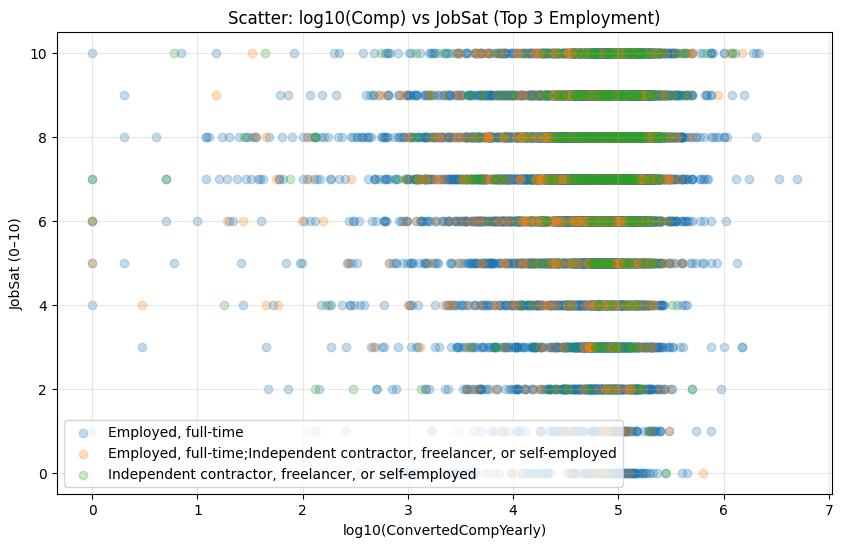

In [11]:
d = dfc.dropna(subset=["ConvertedCompYearly_num","JobSat_num","Employment"]).copy()
print("Rows:", len(d))

d["Comp_log10"] = np.log10(d["ConvertedCompYearly_num"])
top_emp = d["Employment"].value_counts().head(3).index.tolist()
d = d[d["Employment"].isin(top_emp)]

plt.figure(figsize=(10,6))
for e in top_emp:
    sub = d[d["Employment"] == e]
    plt.scatter(sub["Comp_log10"], sub["JobSat_num"], alpha=0.25, label=e)

plt.title("Scatter: log10(Comp) vs JobSat (Top 3 Employment)")
plt.xlabel("log10(ConvertedCompYearly)")
plt.ylabel("JobSat (0–10)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


Interpretation: If one employment group clusters higher on satisfaction or compensation, it suggests different work conditions/comp structures.

#### 2. Scatter Plot for Work Experience vs. Age Group by Country


Compare work experience (`YearsCodePro`) across different age groups (`Age`) and countries (`Country`). Use colors to represent different countries and markers for age groups.


Rows: 17146


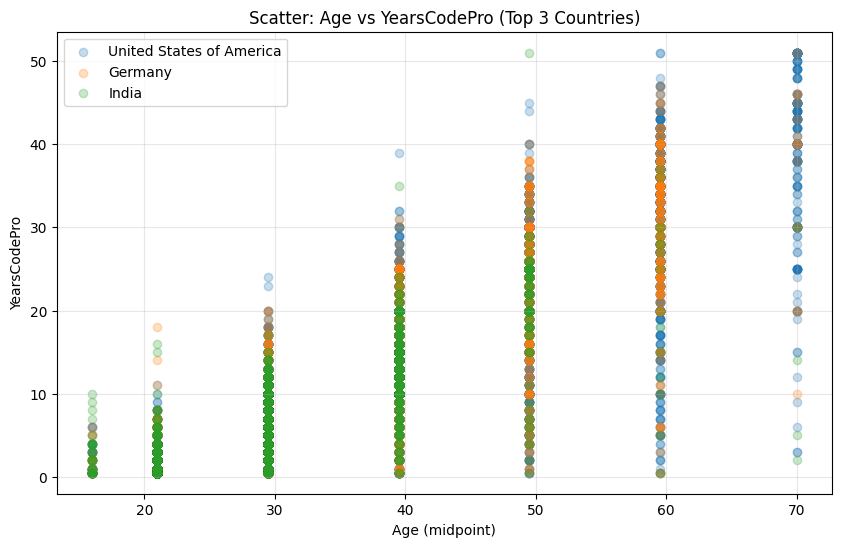

In [12]:
d = dfc.dropna(subset=["AgeNum","YearsCodePro_num","Country"]).copy()
top_c = d["Country"].value_counts().head(3).index.tolist()
d = d[d["Country"].isin(top_c)]
print("Rows:", len(d))

plt.figure(figsize=(10,6))
for c in top_c:
    sub = d[d["Country"] == c]
    plt.scatter(sub["AgeNum"], sub["YearsCodePro_num"], alpha=0.25, label=c)

plt.title("Scatter: Age vs YearsCodePro (Top 3 Countries)")
plt.xlabel("Age (midpoint)")
plt.ylabel("YearsCodePro")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


Interpretation: Different slopes/spreads can reflect different career entry ages, education patterns, or sampling differences.

### Final Step: Review


With these scatter plots, you will have analyzed data relationships across multiple dimensions, including compensation, job satisfaction, employment types, and demographics, to uncover meaningful trends in the developer community.


### Summary


After completing this lab, you will be able to:
- Analyze how numerical variables relate across specific groups, such as employment types and countries.
- Use scatter plots effectively to represent multiple variables with color, size, and markers.
- Gain insights into compensation, satisfaction, and demographic trends using advanced scatter plot techniques.


## Authors:
Ayushi Jain


### Other Contributors:
- Rav Ahuja
- Lakshmi Holla
- Malika


<!--## Change Log
|Date (YYYY-MM-DD)|Version|Changed By|Change Description|
|-|-|-|-|               
|2024-10-07|1.2|Madhusudan Moole|Reviewed and updated lab|                                                                                      
|2024-10-06|1.0|Raghul Ramesh|Created lab|-->


Copyright © IBM Corporation. All rights reserved.
